In [1]:
import os

%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
DATA_PATH = "/home/wangc21/datasets/pool/images"

In [3]:
class PoolDataset(torch.utils.data.Dataset):
    def __init__(self, label_path, transform = None):
        self.labels = pd.read_csv(label_path, sep = ",", header = None).values
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_idx, label = self.labels[idx][0], self.labels[idx][1]
        image = cv2.imread(os.path.join(DATA_PATH, img_idx))
        return (image, label)

In [4]:
# data augmentation

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees = 360),
    transforms.ColorJitter(brightness = 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

data_train = PoolDataset(os.path.join(DATA_PATH, "train_labels.csv"), transform = train_transforms)
print(len(data_train))
data_test = PoolDataset(os.path.join(DATA_PATH, "test_labels.csv"), transform = test_transforms)
print(len(data_test))

12824
3176


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout2d(0.1)
        self.fc = nn.Linear(20 * 20 * 64, 16)
        
    def forward(self, x):
        # HWC to CHW
        x = x.permute(0, 3, 1, 2)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim = 1)
        return output
    
    def loss(self, prediction, label):
        loss = F.cross_entropy(prediction, label)
        return loss

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    print("Epoch %d" % epoch)
    model.train()
    losses = []
    
    # stochastic gradient descent
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device = device, dtype = torch.float)
        label = label.to(device = device, dtype = torch.long)

        # reset gradients
        optimizer.zero_grad()
        
        # make prediction
        output = model(data)
        
        # compute error gradients
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # print loss every 8 batch iterations
        if i % 8 == 0:
            print("Batch Iteration %d, Train Loss: %.6f" % (i, loss.item()))
    
    return losses


def test(model, device, test_loader):
    model.eval()
    losses = []
    
    correct = 0
    with torch.no_grad():
        for (data, label) in test_loader:
            data = data.to(device = device, dtype = torch.float)
            label = label.to(device = device, dtype = torch.long)
            output = model(data)
            loss = model.loss(output, label)
            losses.append(loss.item())
            
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
    test_loss = np.mean(losses)

    print("\nTest Loss: {}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return losses, test_loss

Using: cuda
Epoch 1
Batch Iteration 0, Train Loss: 2.925354
Batch Iteration 8, Train Loss: 2.426385
Batch Iteration 16, Train Loss: 0.998677
Batch Iteration 24, Train Loss: 0.560973

Test Loss: 0.3226932263541652, Accuracy: 2873/3176 (90%)

Epoch 2
Batch Iteration 0, Train Loss: 0.252217
Batch Iteration 8, Train Loss: 0.185714
Batch Iteration 16, Train Loss: 0.062241
Batch Iteration 24, Train Loss: 0.047421

Test Loss: 0.03609679621037287, Accuracy: 3140/3176 (99%)

Epoch 3
Batch Iteration 0, Train Loss: 0.045337
Batch Iteration 8, Train Loss: 0.019327
Batch Iteration 16, Train Loss: 0.022808
Batch Iteration 24, Train Loss: 0.020265

Test Loss: 0.016644602447513535, Accuracy: 3157/3176 (99%)

Epoch 4
Batch Iteration 0, Train Loss: 0.009347
Batch Iteration 8, Train Loss: 0.011650
Batch Iteration 16, Train Loss: 0.012158
Batch Iteration 24, Train Loss: 0.018843

Test Loss: 0.009977627759681695, Accuracy: 3160/3176 (99%)

Epoch 5
Batch Iteration 0, Train Loss: 0.008942
Batch Iteration 8, 

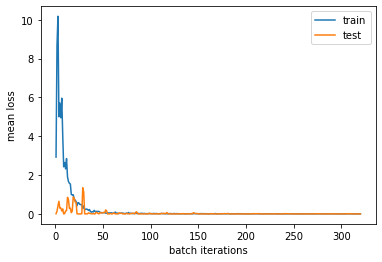

In [8]:
# hyperparameters
EPOCHS = 10
TRAIN_BATCH_SIZE = 400
TEST_BATCH_SIZE = 99
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# hardware device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: %s" % device)
kwargs = {'num_workers': 0,
          'pin_memory': True} if use_cuda else {}

# data loaders
train_loader = torch.utils.data.DataLoader(data_train, batch_size = TRAIN_BATCH_SIZE,
                                           shuffle = True, drop_last = True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = TEST_BATCH_SIZE,
                                          shuffle = False, drop_last = True, **kwargs)  

# training objects
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

# training loop
train_curve = []
test_curve = []
best_loss = np.inf
for epoch in range(1, EPOCHS + 1):
    train_losses = train(model, device, train_loader, optimizer, epoch)
    test_losses, test_loss = test(model, device, test_loader)
    train_curve.extend(train_losses)
    test_curve.extend(test_losses)
    
    # save best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), os.path.join(DATA_PATH, "checkpoints/epoch_%d.pt" % epoch))
        
# plot loss functions
plt.plot(np.arange(EPOCHS * 32) + 1, train_curve, label = "train")
plt.plot(np.arange(EPOCHS * 32) + 1, test_curve, label = "test")
plt.legend()
plt.xlabel('batch iterations')
plt.ylabel('mean loss')
plt.show()